## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

folder_path = r'D:\WORK\FLOODNET\SensorData'
flood_files = [f for f in os.listdir( folder_path) if f.endswith('.csv')]

flood_data = pd.DataFrame()
for flood_file in flood_files:
    temp = pd.read_csv(os.path.join( folder_path , flood_file))
    flood_data = pd.concat( [flood_data, temp] )

flood_data['time'] = pd.to_datetime( flood_data['time'] )
flood_data.head()

c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


,time,deployment_id,dev_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,batt_v,f_cnt,dist_mm,lat,...,date_deployed,deploy_type,sensor_display_name,sensor_address_street,sensor_address_borough,sensor_address_neighborhood,nearest_weather_station,nearest_tidal_id,mounted_over,sensor_mount
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,fs-00010,0.0,0.0,0.0,4.092,70504.0,2356.0,40.809830,...,"December 12, 2021",pluvial,M - 126th St/7th Av,W 126th and Adam Clayton Powell Jr Blvd,Manhattan,Harlem,nyc-micronet-mhchel,NaN,Sidewalk,Streetsign Post
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,fs-00025,0.0,0.0,0.0,4.074,4619.0,2798.0,40.695371,...,"June 10, 2022",pluvial,Q - 108th Ave/159th St,108 Ave and 159 St,Queens,South Jamaica,nyc-micronet-qnsozo,NaN,Sidewalk,Streetsign Post
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,fs-00022,-130.0,0.0,0.0,4.126,243336.0,1632.0,40.591360,...,"December 10, 2021",pluvial,Q - Beach 84 St,Beach 84 St,Queens,Far Rockaway,nyc-micronet-qnsozo,usgs-tidal-01311850,Sidewalk,Fence
3,2022-10-01 00:00:27.073000+00:00,duly_star_bee,fs-00001,2.0,0.0,0.0,4.060,70639.0,2501.0,40.811159,...,"December 12, 2021",pluvial,M - Morningside Av/125th St,Morningside & 125th,Manhattan,Harlem,nyc-micronet-mhchel,NaN,Sidewalk,Streetsign Post
4,2022-10-01 00:00:35.790000+00:00,future_aqua_wildcat,fs-00032,1.0,0.0,0.0,4.116,93419.0,2280.0,40.619373,...,"July 22, 2022",pluvial,SI - Lyon Pl/Devens St,Lyon Pl and Devens St,Staten Island,Graniteville,NaN,NaN,Sidewalk,Streetsign Post


In [2]:
flood_data.to_parquet( os.path.join( folder_path, 'all_flood_data.parquet') )
flood_data = pd.read_parquet( os.path.join( folder_path, 'all_flood_data.parquet') )

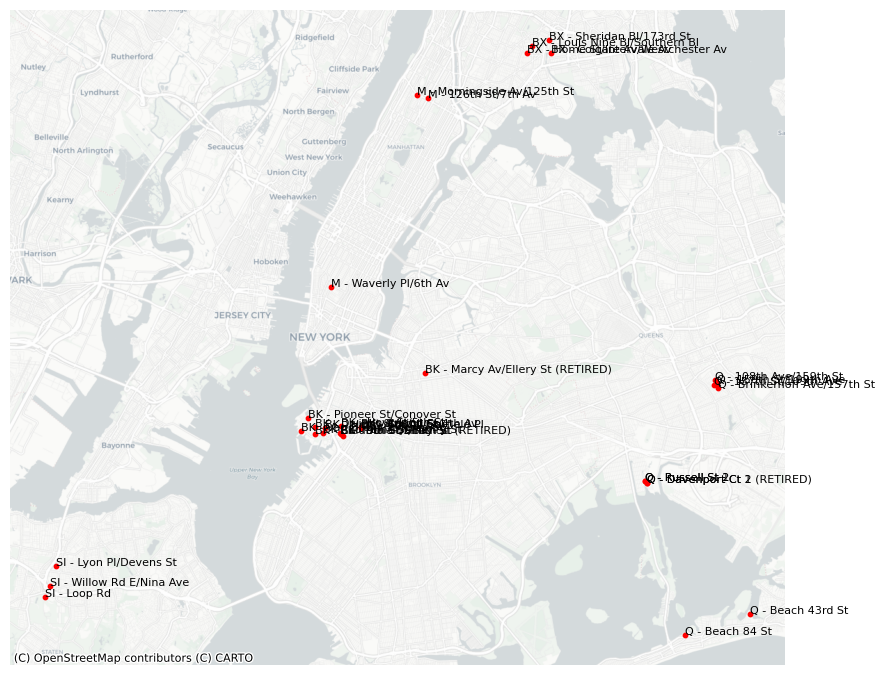

In [3]:
import geopandas as gpd
import contextily as ctx

sensor_locations = flood_data.groupby('deployment_id').agg({
    'lat': 'first',
    'lon': 'first',
    'sensor_display_name': 'first'
})

sensor_geo = gpd.GeoDataFrame(
    sensor_locations, geometry=gpd.points_from_xy(sensor_locations.lon, sensor_locations.lat), crs=4326 )
sensor_geo = sensor_geo.to_crs(3857)

sensor_geo.plot( color='red', markersize=10, figsize=(10,10) )
# annotate the sensors by sensor_display_name
for idx, row in sensor_geo.iterrows():
    plt.annotate( row['sensor_display_name'], (row['geometry'].x, row['geometry'].y) , fontsize=8 )

ctx.add_basemap( plt.gca(), source=ctx.providers.CartoDB.Positron )
plt.axis('off');

In [4]:
pd.set_option('display.max_columns', None)
flood_data = flood_data.drop(['dev_id','batt_v','f_cnt','dist_mm','sensor_address_street','sensor_address_borough','nearest_weather_station','nearest_tidal_id','mounted_over','sensor_mount'], axis=1 )
flood_data.head()

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,0.0,0.0,40.809830,-73.948100,"December 12, 2021",pluvial,M - 126th St/7th Av,Harlem
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,0.0,0.0,40.695371,-73.794115,"June 10, 2022",pluvial,Q - 108th Ave/159th St,South Jamaica
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,-130.0,0.0,0.0,40.591360,-73.809960,"December 10, 2021",pluvial,Q - Beach 84 St,Far Rockaway
3,2022-10-01 00:00:27.073000+00:00,duly_star_bee,2.0,0.0,0.0,40.811159,-73.954033,"December 12, 2021",pluvial,M - Morningside Av/125th St,Harlem
4,2022-10-01 00:00:35.790000+00:00,future_aqua_wildcat,1.0,0.0,0.0,40.619373,-74.147436,"July 22, 2022",pluvial,SI - Lyon Pl/Devens St,Graniteville


734952


<AxesSubplot:xlabel='time'>

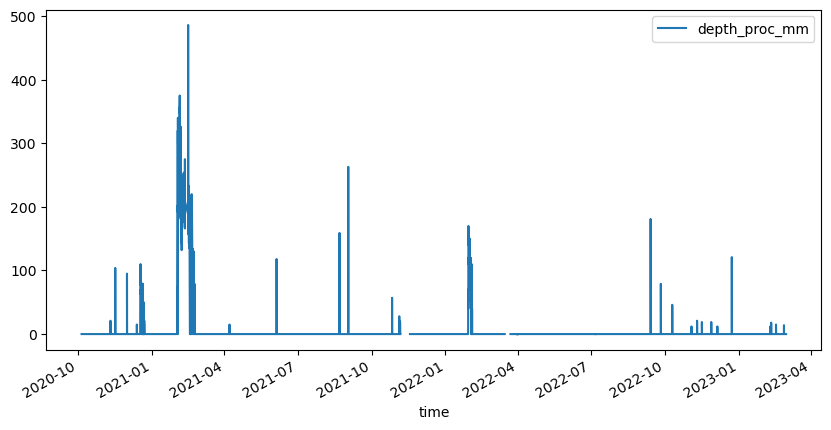

In [5]:
print( flood_data[ flood_data['deployment_id'] == 'daily_new_falcon' ].shape[0] )

flood_data = flood_data.dropna( axis = 0 , subset = ['deployment_id'] )
flood_data[ flood_data['deployment_id'] == 'daily_new_falcon' ].plot( x = 'time' , y = 'depth_proc_mm' , figsize = (10,5) )

In [7]:
flood_data.shape[0] , flood_data.dropna( axis = 0 , subset = ['depth_raw_mm','depth_filt_mm','depth_proc_mm'] ).shape[0]

# filter if ['depth_raw_mm','depth_filt_mm','depth_proc_mm'] is null in reverse
nones = flood_data[ flood_data['depth_raw_mm'].isnull() & flood_data['depth_filt_mm'].isnull() & flood_data['depth_proc_mm'].isnull() ]

nones['deployment_id'].value_counts().head()


vastly_saving_whale     359476
openly_driven_tarpon    249411
early_still_frog         39477
gladly_mint_snail        16545
jolly_tender_squid       15592
Name: deployment_id, dtype: int64

### Add neighborhoods CDTA's to DF

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,0.0,0.0,40.809830,-73.948100,"December 12, 2021",pluvial,M - 126th St/7th Av,Harlem,MN10 Harlem (CD 10 Equivalent)
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,0.0,0.0,40.695371,-73.794115,"June 10, 2022",pluvial,Q - 108th Ave/159th St,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,-130.0,0.0,0.0,40.591360,-73.809960,"December 10, 2021",pluvial,Q - Beach 84 St,Far Rockaway,QN14 The Rockaways (CD 14 Approximation)
3,2022-10-01 00:00:27.073000+00:00,duly_star_bee,2.0,0.0,0.0,40.811159,-73.954033,"December 12, 2021",pluvial,M - Morningside Av/125th St,Harlem,MN09 Morningside Heights-Hamilton Heights (CD ...
4,2022-10-01 00:00:35.790000+00:00,future_aqua_wildcat,1.0,0.0,0.0,40.619373,-74.147436,"July 22, 2022",pluvial,SI - Lyon Pl/Devens St,Graniteville,SI01 North Shore (CD 1 Equivalent)


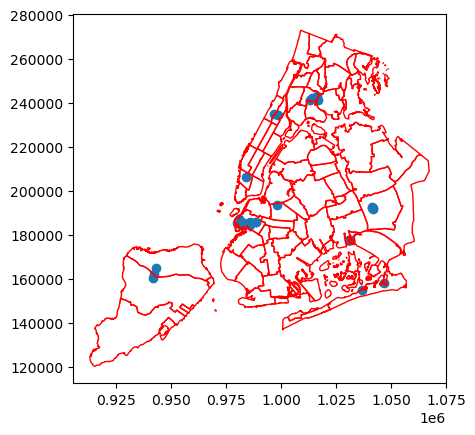

In [8]:
import geopandas as gpd

path = r"C:\Git_Repo\FloodAnalysis\DATA\NYCDTA_flood_reports_detections_join.geojson"
cdta = gpd.read_file(path)

unique_Sensors = flood_data.groupby('deployment_id').agg({
    'lat':'first',
    'lon':'first'
})

geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )
geo_sensors = geo_sensors.to_crs('EPSG:2263')

fig,ax = plt.subplots()
geo_sensors.plot(ax=ax)
cdta.plot(ax=ax, ec='red', fc='none')

geo_sensors = geo_sensors.sjoin(cdta[['CDTAName','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

all_data = flood_data.join(geo_sensors, on='deployment_id')
all_data.head()

## Remove Non-Flood Events

In [45]:
events_path = r"D:\WORK\FLOODNET\EventsData (upto 07_22).xlsx"
events = pd.read_excel(events_path, sheet_name='ALL')
print( events.shape[0] )
events = events.drop_duplicates(subset=['Deployment_id','Start_time','End_time'])
print( events.shape[0] )
events.head()

618
618


,Deployment_id,Start_time,End_time,Duration,Duration (mins),Class,Borough,Type,Deployment Date,Latitude,Longitude,Address,Unnamed: 12,Unnamed: 13,Legend,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,boring_olive_stingray,2022-06-11 19:41:31,2022-06-11 19:43:37,00:02:06,2.100000,1,Queens,pluvial,2022-06-10,40.69395,-73.793087,109 Ave and 159 St,NaN,NaN,NaN,NaN,~measurements during events,126040.5667
1,boring_olive_stingray,2022-07-04 20:25:15,2022-07-04 20:27:20,00:02:05,2.083333,1,Queens,pluvial,2022-06-10,40.69395,-73.793087,109 Ave and 159 St,NaN,NaN,NaN,NaN,NaN,NaN
2,boring_olive_stingray,2022-07-04 21:08:20,2022-07-04 21:10:25,00:02:05,2.083333,1,Queens,pluvial,2022-06-10,40.69395,-73.793087,109 Ave and 159 St,NaN,NaN,NaN,NaN,NaN,NaN
3,boring_olive_stingray,2022-07-04 21:19:55,2022-07-04 21:23:05,00:03:10,3.166667,1,Queens,pluvial,2022-06-10,40.69395,-73.793087,109 Ave and 159 St,NaN,NaN,NaN,NaN,NaN,NaN
4,boring_olive_stingray,2022-07-04 23:43:50,2022-07-04 23:47:00,00:03:10,3.166667,1,Queens,pluvial,2022-06-10,40.69395,-73.793087,109 Ave and 159 St,NaN,NaN,NaN,NaN,NaN,NaN


### Are there overlapping events?

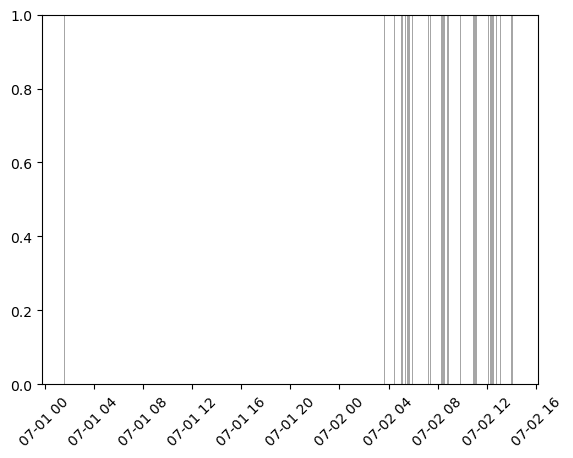

In [69]:
garf_events = events[events['Deployment_id'] == 'daily_gentle_beetle' ]
garf_events = garf_events[ (garf_events['Start_time'].dt.year == 2022) & (garf_events['Start_time'].dt.month > 6) ]
garf_events.apply( lambda x: plt.axvspan( x['Start_time'],x['End_time'] , facecolor = 'grey', edgecolor=None, alpha=0.7 ), axis=1  )
plt.xticks(rotation=45);

### Remove Non-Flood Events
- Iterate over each deployment_id 
- Filter data and events to id
- Create a during flood event filled with 0's
- Iterate over events per sensors and assign 1 to rows between `Start_time` and `End_time`

In [10]:
import random
ids = all_data['deployment_id'].unique()
random.shuffle(ids)

cleaned_data = pd.DataFrame()

for id in ids:
    
    single_sensor = all_data[ (all_data['deployment_id'] == id) ].copy()
    
    single_sensor['time_2'] = pd.to_datetime( single_sensor['time'].dt.strftime('%Y-%m-%d %H:%M:%S') )
    single_sensor['during_flood'] = 0

    sensor_event = events[ events['Deployment_id'] == id ]
    sensor_event = sensor_event[['Deployment_id','Start_time','End_time']]

    sensor_event['Start_time'] = pd.to_datetime( sensor_event['Start_time'] )
    sensor_event['End_time'] = pd.to_datetime( sensor_event['End_time'] )

    for index, single_event in sensor_event.iterrows():
        single_sensor.loc[ (single_sensor['time_2'] > single_event['Start_time']) & (single_sensor['time_2'] < single_event['End_time']) , 'during_flood' ] = 1

    cleaned_data = pd.concat( [cleaned_data, single_sensor] )
   
cleaned_data[ cleaned_data['during_flood'] == 1 ].head()

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName,time_2,during_flood
56447,2022-07-05 04:06:13.211000+00:00,total_moccasin_dolphin,1717.0,1717.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-07-05 04:06:13,1
56458,2022-07-05 04:07:15.867000+00:00,total_moccasin_dolphin,-2.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-07-05 04:07:15,1
276888,2022-06-12 01:29:33.552000+00:00,total_moccasin_dolphin,959.0,959.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-06-12 01:29:33,1
276911,2022-06-12 01:30:36.343000+00:00,total_moccasin_dolphin,0.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-06-12 01:30:36,1
347417,2022-06-14 18:54:54.583000+00:00,total_moccasin_dolphin,711.0,711.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-06-14 18:54:54,1


### Assign 0 or flood depth based on clean depth

In [16]:
import numpy as np
cleaned_data['clean_depth'] = np.where( cleaned_data['during_flood'] == 1 , cleaned_data['depth_proc_mm'] , 0 )
cleaned_data.head(3)

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName,time_2,during_flood,clean_depth
14,2022-10-01 00:00:59.213000+00:00,total_moccasin_dolphin,0.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-10-01 00:00:59,0,0.0
36,2022-10-01 00:02:02.053000+00:00,total_moccasin_dolphin,1.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-10-01 00:02:02,0,0.0
54,2022-10-01 00:03:05.433000+00:00,total_moccasin_dolphin,0.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-10-01 00:03:05,0,0.0


### Remove Data after Aug 22nd  
Manual tagging is not done yet.

In [18]:
filtered_data = cleaned_data.copy()
filtered_data['smooth_depth_in'] = filtered_data['clean_depth'] / 25.4

# No manual tagging after August 2022
filtered_data = filtered_data[ filtered_data['time_2'] < pd.to_datetime("2022-08-01") ]

filtered_data.head(3)


,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName,time_2,during_flood,clean_depth,smooth_depth_in
14,2022-07-01 00:01:32.917000+00:00,total_moccasin_dolphin,-9.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-07-01 00:01:32,0,0.0,0.0
55,2022-07-01 00:05:44.200000+00:00,total_moccasin_dolphin,-8.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-07-01 00:05:44,0,0.0,0.0
82,2022-07-01 00:08:53.780000+00:00,total_moccasin_dolphin,-6.0,0.0,0.0,40.693297,-73.794337,"June 10, 2022",pluvial,Q - 157th St/109th Ave,South Jamaica,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,2022-07-01 00:08:53,0,0.0,0.0


## PLOTS

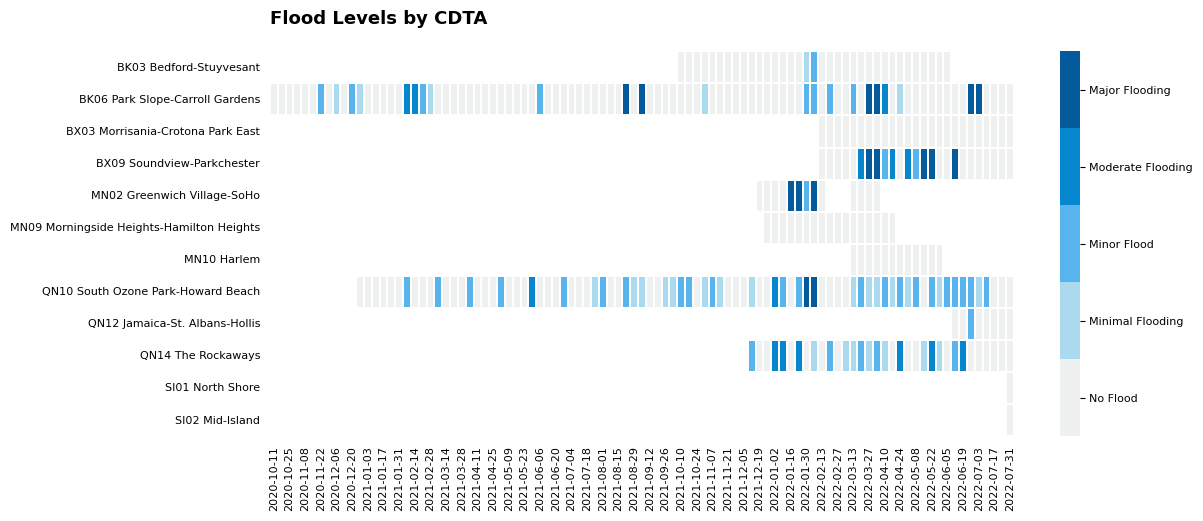

In [19]:
# ---- FORMAT & PLOT ----
# Simplify Depth

# Segmented Color Map
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

filtered_data['smooth_depth_cut'] = pd.cut(
    filtered_data['smooth_depth_in'],
    bins=[-1, 0.25, 4, 12, 24, 1000 ],
    labels=[ 0, 1, 2, 3, 4]
)

# pivot to get max
pt = pd.pivot_table(
    data = filtered_data.sort_values('CDTAName'),
    columns = pd.Grouper(key='time', freq='1W'),
    index = 'CDTAName',
    values='smooth_depth_cut',
    aggfunc='max'
)

# Format Columns - Time format
pt.columns = pt.columns.strftime('%Y-%m-%d')
pt.index = [x.split(" (")[0] for x in pt.index]

import seaborn as sns
plt.figure( figsize=(12, 5) )
# ---- Heatmap ----
ax = sns.heatmap(
    pt.astype(float),
    linewidths=0.025,
    linecolor='white',
    square=False,
    cmap = custom_ramp,
    mask=pt.isnull(),
)

ax.set_facecolor('#FFFFFF') # No Data is White
ax.tick_params( axis='both', left=False, bottom=False, labelsize=8 )

# Simplify the colors bar
n = len(values)
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8)                                        

plt.xlabel('')
plt.ylabel('')
plt.savefig( r'D:\WORK\FLOODNET\VISUALS\CDTA_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.title( "Flood Levels by CDTA", fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05)
plt.show();

In [20]:
RH_data = filtered_data.dropna(subset=['CDTAName'],axis=0)
RH_data = RH_data[ RH_data['CDTAName'].str.contains("BK06") ]
RH_data.head()

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName,time_2,during_flood,clean_depth,smooth_depth_in,smooth_depth_cut
29984,2021-10-07 21:25:22.929466+00:00,highly_equal_doe,-10.0,0.0,0.0,40.672626,-73.993563,2021-10-04T00:00:00-04:00,pluvial,NaN,NaN,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-10-07 21:25:22,0,0.0,0.0,0
29988,2021-10-07 21:26:25.469678+00:00,highly_equal_doe,-10.0,0.0,0.0,40.672626,-73.993563,2021-10-04T00:00:00-04:00,pluvial,NaN,NaN,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-10-07 21:26:25,0,0.0,0.0,0
29993,2021-10-07 21:27:28.379666+00:00,highly_equal_doe,-10.0,0.0,0.0,40.672626,-73.993563,2021-10-04T00:00:00-04:00,pluvial,NaN,NaN,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-10-07 21:27:28,0,0.0,0.0,0
29997,2021-10-07 21:28:31.188897+00:00,highly_equal_doe,-10.0,0.0,0.0,40.672626,-73.993563,2021-10-04T00:00:00-04:00,pluvial,NaN,NaN,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-10-07 21:28:31,0,0.0,0.0,0
30003,2021-10-07 21:29:34.772911+00:00,highly_equal_doe,-10.0,0.0,0.0,40.672626,-73.993563,2021-10-04T00:00:00-04:00,pluvial,NaN,NaN,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-10-07 21:29:34,0,0.0,0.0,0


Text(0, 1.05, 'Flood Events by Day at BK06')

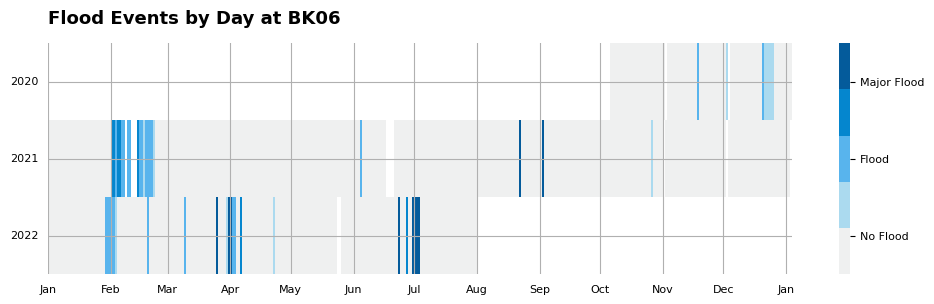

In [70]:
RH_data['year'] = RH_data['time'].dt.year

# Get week number
RH_data['week'] = RH_data['time'].dt.dayofyear
RH_data['month'] = RH_data['time'].dt.month

rh_daily =pd.pivot_table(
    data = RH_data,
    columns = ['month','week'],
    index = 'year',
    values= 'smooth_depth_cut',
    aggfunc='max'
).astype( float )

plt.figure( figsize=(12,3) )
ax = sns.heatmap( rh_daily, cmap= custom_ramp, lw=0.0025 )
ax.tick_params( axis='both', left=False, bottom=False, labelsize=8 )

values = ['No Flood', 'Flood', 'Major Flood']
n = len(values)

colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8)    

# adjust tick frequency
import matplotlib.dates as mdates
ax.xaxis.set_major_locator( mdates.MonthLocator(interval=1) )
ax.xaxis.set_major_formatter( mdates.DateFormatter('%b') )

# x-tick labels, rotate
plt.xticks(rotation=0)
plt.grid(True)

# Rotate y labels
plt.ylabel('')
plt.xlabel('')
plt.yticks(rotation=0)
plt.title( "Flood Events by Day at BK06", fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05)
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\RH_heatmap.pdf', dpi=300, bbox_inches='tight')

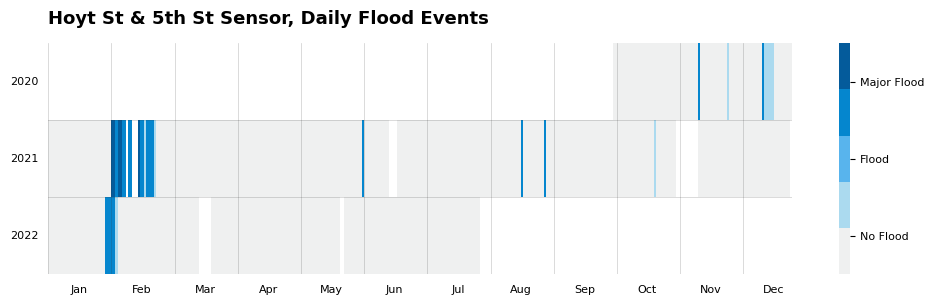

In [71]:

rh_daily =pd.pivot_table(
    data = RH_data[RH_data['deployment_id'] == 'daily_new_falcon' ],
    columns = 'week',
    index = 'year',
    values= 'smooth_depth_cut',
    aggfunc='max'
).astype( float )

plt.figure( figsize=(12, 3) )
ax = sns.heatmap( rh_daily, cmap= custom_ramp )
ax.tick_params( axis='both', left=False, bottom=False, labelsize=8 )

n = len(values)

colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8)  

# Custom x lables
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# months = ['Jan','Feb','Mar']
plt.xticks( [(i*31)+15 for i in range(len(months))] , labels= months , rotation = 0, fontsize=8, ha='center')

# Ad grids
[ plt.axvline(i*31, color = '#333', alpha=0.25 , lw=0.5 ) for i in range(len(months))]
[ plt.axhline(i, color = '#333', alpha=0.25 , lw=0.5 ) for i in range(1,3) ]

plt.ylabel('')
plt.xlabel('')
plt.yticks(rotation=0)
plt.title( "Hoyt St & 5th St Sensor, Daily Flood Events", fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05) 
plt.savefig( r'D:\WORK\FLOODNET\VISUALS\Hoyt5.pdf', dpi=300, bbox_inches='tight')

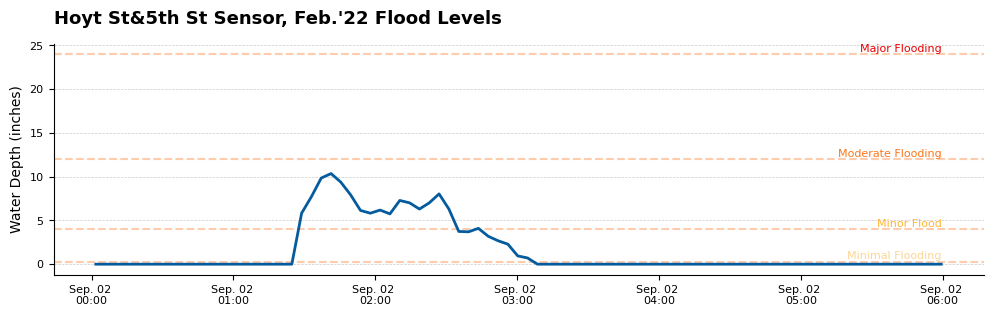

In [72]:

hoyt_data = RH_data[
    (RH_data['deployment_id'] == 'daily_new_falcon') &
    # (RH_data['time'].dt.year.isin([2021])) & 
    # (RH_data['time'].dt.month.isin([8,9]) ) &
    (RH_data['time_2'] < pd.to_datetime('2021-09-02 06:00:00') ) &
    (RH_data['time_2'] > pd.to_datetime('2021-09-02') )
    ].copy()

hoyt_data = hoyt_data[ ~hoyt_data['depth_proc_mm'].isnull() ].reset_index()

plt.figure( figsize=(12, 3) )
sns.lineplot(
    data = hoyt_data,
    x = 'time',
    y = 'smooth_depth_in',
    lw = 2,
    color = '#045B9E',
    zorder = 2
)

# Annotate over the axhline
colors = ['#FCD695','#FFB533','#FC751A','#E80000']
values = ['Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']
bins=[0.25,4, 12, 24 ]

for (depth, flood_level, color) in zip(bins, values, colors):
    plt.axhline(depth, color ='#FE9B5D', alpha=0.5 , lw=1.5, ls ='--' , zorder = 1)
    plt.annotate( flood_level, xy = (hoyt_data['time'].max(),depth+0.1), ha='right', va = 'bottom' , color = color, fontsize=8 )

# hide every 2nd xtick
plt.xticks( fontsize=8 )
plt.yticks( fontsize=8 )

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b. %d \n%H:%M'))

# Grey overlays for non 0 values
def group_consecutive(data):
    import numpy as np
    return np.split(data, np.where(np.diff(data) != 1)[0]+1)

hoyt_data['order'] = [i for i in range(len(hoyt_data))]
non_zero = hoyt_data[ hoyt_data['smooth_depth_in'] > 0 ]

for count,nz in enumerate(group_consecutive(non_zero['order'].values)):
    if len(nz) > 300:
        nz_time_min = hoyt_data['time'].iloc[nz[0]]
        nz_time_max = hoyt_data['time'].iloc[nz[-1]]
        # filter data by dates
        nz_data = hoyt_data[ (hoyt_data['time'] >= nz_time_min) & (hoyt_data['time'] <= nz_time_max) ]
        f_max = nz_data['smooth_depth_in_2'].max()     
        plt.axvspan( nz_time_min, nz_time_max, fc='#333', ec=None, alpha=0.15, zorder=0 )
        plt.annotate( 
            "Flood Duration: {}days \nMax Depth: {}in. ".format( (pd.to_datetime(nz_time_max) - pd.to_datetime(nz_time_min)).days, round(f_max,1) ) ,
            xy = ( 
                nz_time_max , 
                hoyt_data['smooth_depth_in_2'].max() - (count*0.5)
                ), ha='right', va = 'top' , color = '#333', fontsize=8 )
        
plt.grid( axis='y', alpha=0.25 , zorder=-1 , lw=0.5, ls='--', color='#333')
plt.title( "Hoyt St&5th St Sensor, Feb.'22 Flood Levels" , fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05)
plt.ylabel( "Water Depth (inches)" )
plt.xlabel( "" )
sns.despine()
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\Hoyt5_timeseries.pdf', dpi=300, bbox_inches='tight')


### Remove Snow Events  
There are unexpected peaks for Hoyt St, Sensor at 2021, Feb, March.  
These are because of snow pile up under the sensors

In [74]:
RH_data = RH_data[~RH_data['sensor_display_name'].isnull()].copy()

RH_data.loc[
    RH_data['sensor_display_name'].str.contains('Hoyt') & (RH_data['year'] == 2021) & (RH_data['month'] == 2),
    "smooth_depth_in"
] = 0

RH_data.loc[
    RH_data['sensor_display_name'].str.contains('Hoyt') & (RH_data['year'] == 2021) & (RH_data['month'] == 3),
    "smooth_depth_in"
] = 0

RH_data[ RH_data['sensor_display_name'].str.contains('Hoyt')].head()


,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_neighborhood,CDTAName,time_2,during_flood,clean_depth,smooth_depth_in,smooth_depth_cut,year,week,month
0,2021-09-01 00:00:02.592801+00:00,daily_new_falcon,1.0,0.0,0.0,40.676672,-73.994591,"October 5, 2020",pluvial,BK - Hoyt St/5th St,Gowanus,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-09-01 00:00:02,0,0.0,0.0,0,2021,244,9
3,2021-09-01 00:04:09.209148+00:00,daily_new_falcon,8.0,0.0,0.0,40.676672,-73.994591,"October 5, 2020",pluvial,BK - Hoyt St/5th St,Gowanus,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-09-01 00:04:09,0,0.0,0.0,0,2021,244,9
7,2021-09-01 00:08:15.827057+00:00,daily_new_falcon,2.0,0.0,0.0,40.676672,-73.994591,"October 5, 2020",pluvial,BK - Hoyt St/5th St,Gowanus,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-09-01 00:08:15,0,0.0,0.0,0,2021,244,9
11,2021-09-01 00:12:22.473472+00:00,daily_new_falcon,1.0,0.0,0.0,40.676672,-73.994591,"October 5, 2020",pluvial,BK - Hoyt St/5th St,Gowanus,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-09-01 00:12:22,0,0.0,0.0,0,2021,244,9
15,2021-09-01 00:16:29.114276+00:00,daily_new_falcon,-1.0,0.0,0.0,40.676672,-73.994591,"October 5, 2020",pluvial,BK - Hoyt St/5th St,Gowanus,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,2021-09-01 00:16:29,0,0.0,0.0,0,2021,244,9



(January 28th-29th Blizzard)[https://storymaps.arcgis.com/stories/3cc5880df4464dfb860bf89476ba6eeb]  
February 19th Snow Squall Event...snow | wind   
December 23rd Strong Low Pressure/Coastal Flooding/Arctic Outbreak Event


0.6971639606996028 BK - 4th Av/Garfield Pl
6.334364454443195 BK - Hoyt St/5th St
25.997852541159627 BK - Lorraine St/Henry St
18.848425196850396 BK - Van Brunt St/Reed St
2022-06-23 09:55:50 - 2022-06-23 10:02:10
0.21747281589801276 BK - Henry St/Mill St
2.0163367429538597 BK - Dwight St/King St
14.640534063676823 BK - Carroll St/4th Av


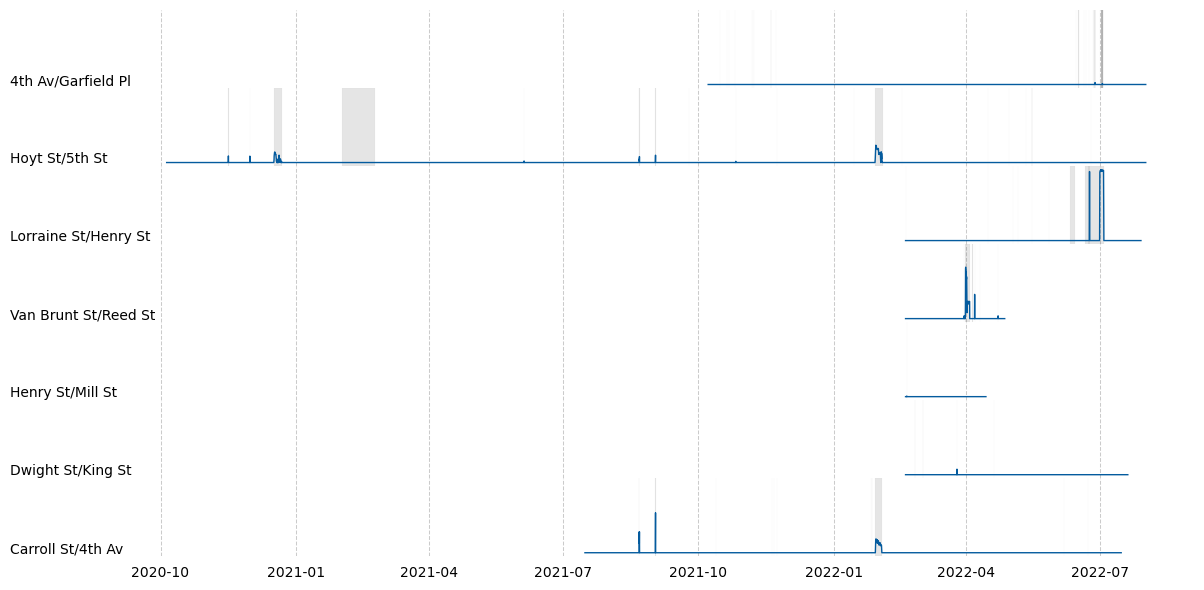

In [104]:
import seaborn as sns

# definition to group consecutive values in a list for order variable
def group_consecutive(data):
    import numpy as np
    return np.split(data, np.where(np.diff(data) != 1)[0]+1)

time_data = RH_data.groupby( ['deployment_id',pd.Grouper(key='time',freq="2H")] ).agg({
    'smooth_depth_in':'mean',
    'sensor_display_name':'first',
    }).reset_index()

time_data = time_data[ time_data['deployment_id'] != 'overly_heroic_squid' ]
time_data = time_data.dropna(axis=0)
time_data = time_data[ ~time_data['sensor_display_name'].str.contains("RET") ]

time_data = time_data.groupby('deployment_id').filter(lambda x: sum(x['smooth_depth_in']) > 0 )

fig,axs = plt.subplots(nrows=time_data['deployment_id'].nunique(),figsize=(12,6), sharex=True, sharey=True )

for count,id in enumerate(time_data['deployment_id'].unique()):
    ax = axs[count]
    temp = time_data[time_data['deployment_id']==id].copy()

    print( temp['smooth_depth_in'].max() , temp['sensor_display_name'].values[0] )
    ax.plot(
        temp['time'], 
        temp['smooth_depth_in'], 
        lw=1 , zorder=count+1,
        color = '#045B9E')

    ax.set_ylabel( temp['sensor_display_name'].values[0].split(" - ")[1] , rotation=0, ha='left')
    # move the y label to the left
    ax.yaxis.set_label_coords(-0.1,0)
    sns.despine( bottom = True, left = True, right=True, ax=ax )
    ax.patch.set_alpha(0)

    #remove xticks
    ax.set_yticks([])
    ax.tick_params(axis='x', bottom=False)
    ax.grid(axis='x', alpha=0.25 , zorder=-1 , lw=0.75, ls='--', color='#333')

    # Iterate over events and filter by id
    single_events = events[events['Deployment_id']==id].copy()
    single_events['Start_time'] = pd.to_datetime(single_events['Start_time'])
    single_events['End_time'] = pd.to_datetime(single_events['End_time'])
    if single_events.shape[0] > 0:
        try:
            for count,event in single_events.iterrows():
                ax.axvspan(event['Start_time'], event['End_time'], alpha=0.2, fc='grey', ec='grey', lw=0.1, zorder=0 )
        except:
            print("{} - {}".format( single_event['Start_time'], single_event['End_time']))


plt.tight_layout( h_pad= 0 , w_pad=0 )
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\RH_timeseries.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [198]:
RH_data[ RH_data['sensor_display_name'].str.contains('Russel') ]['deployment_id'].values[0]

'duly_pro_vervet'

In [199]:
hoyt_data = RH_data[
    (RH_data['deployment_id'] == 'weekly_poetic_guinea') ].copy()

hoyt_data = hoyt_data[ ~hoyt_data['depth_proc_mm'].isnull() ].reset_index()
hoyt_data = hoyt_data[['time_2','smooth_depth_in','smooth_depth_cut']]

hoyt_data['year'] = hoyt_data['time_2'].dt.year

# --- Events
hoyt_events = events[ events['Deployment_id'] == 'daily_new_falcon' ]

fig,axs = plt.subplots ( nrows=hoyt_data['year'].nunique() , figsize=(12,4), sharey=True )

for count,year in enumerate(sorted(hoyt_data['year'].unique())):
    
    ax = axs[count]

    t = hoyt_data[ hoyt_data['year'] == year ].copy()
    t = t.sort_values('time_2')

    ax.fill_between(
        t['time_2'],
        t['smooth_depth_in'],
        color = 'blue',
        alpha = 0.5,
        zorder = 3
    )

    ax.plot(
        t['time_2'],
        t['smooth_depth_in'],
        color = 'blue',
        lw=0.2,
        zorder = 4
    )

    # EVENTS
    annual_hoyt_events = hoyt_events[ hoyt_events['Start_time'].dt.year == year ].copy()
    annual_hoyt_events['Start_time'] = pd.to_datetime( annual_hoyt_events['Start_time'] )
    annual_hoyt_events['End_time'] = pd.to_datetime( annual_hoyt_events['End_time'] )

    annual_hoyt_events.apply( lambda x: ax.axvspan( x['Start_time'],x['End_time'], ymin=0 , facecolor = 'grey', edgecolor='grey', alpha=0.2, zorder=2 ), axis=1  )

    # MONTHS
    ax.xaxis.set_major_locator( mdates.MonthLocator(interval=1) )
    ax.grid( axis='x', lw=0.5, alpha=0.5 )

    ax.set_xlim( pd.to_datetime( f'{year}-01-01'), pd.to_datetime( f'{year}-12-31') )
    ax.set_ylabel( year , rotation=0, ha='right', va='center', fontsize=11 )

    # x-Axis
    ax.plot( [pd.to_datetime( f'{year}-01-01'), pd.to_datetime( f'{year}-12-31')], [0,0], color = '#333',lw=1,zorder=0 )

    if count != hoyt_data['year'].nunique()-1:
        sns.despine( bottom = True, left = True, right=True, ax=ax )
        ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False )
    else:
        sns.despine( bottom = True, left = True, right=True, ax=ax )
        ax.tick_params(axis='both', bottom=False, left=False, labelbottom=True, labelleft=False )

        # x-Axis plot short month names
        ax.set_xticklabels( ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] , rotation=0, fontsize=11, ha='left' )


# set title to plot
plt.suptitle( "Carrol St Sensor, Flood Events by Year", fontsize=13, fontweight='bold', ha = 'left', x=0.13 )

plt.subplots_adjust(hspace=0)
plt.savefig( r'D:\WORK\FLOODNET\VISUALS\Russel_events.pdf' );

KeyError: "None of [Index(['time_2', 'smooth_depth_in', 'smooth_depth_cut'], dtype='object')] are in the [columns]"